In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

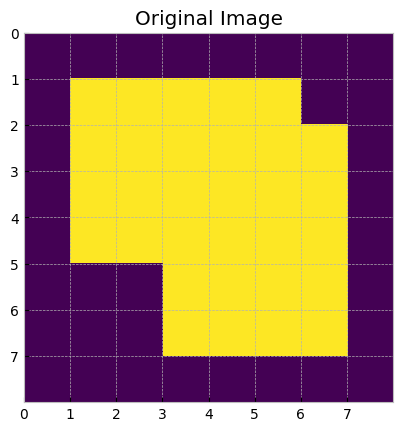

In [2]:
# A 8x8 binary image represented as a numpy array
image = np.array([ [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 1, 0, 0],
         [0, 1, 1, 1, 1, 1, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 1, 1, 1, 1, 0],
         [0, 0, 0, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0] ])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

plot_image(image, 'Original Image')

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            if rms==0:
                image_norm.append(0)
            else:
                image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

In [4]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

C:\Users\shrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


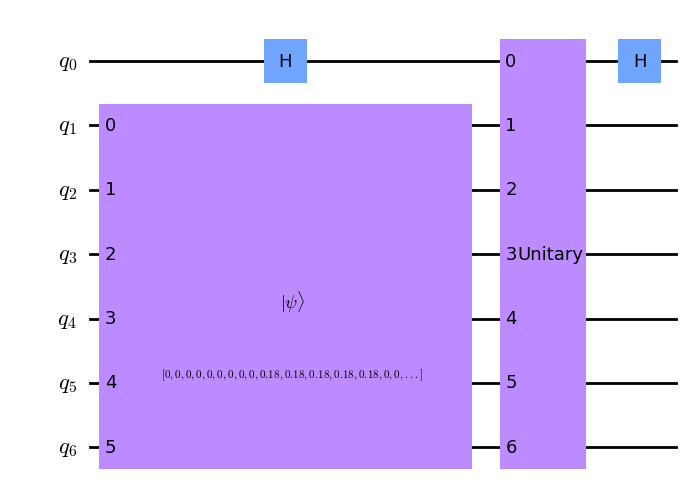

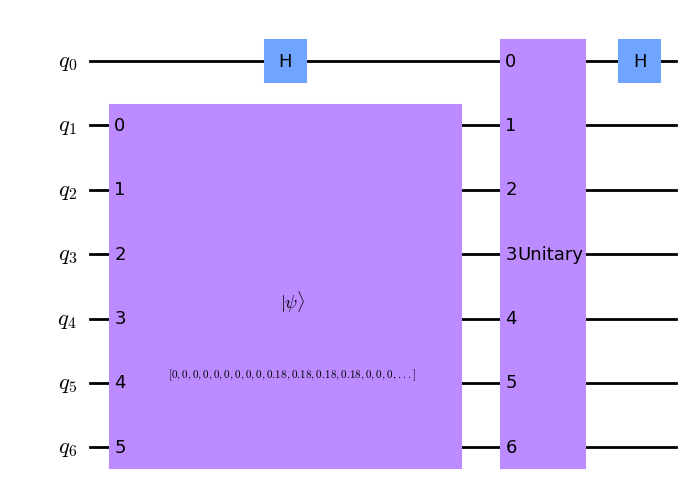

In [5]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [6]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
#print(np.array(sv_h))
display(array_to_latex(np.array(sv_h)[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(np.array(sv_v)[:30], max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

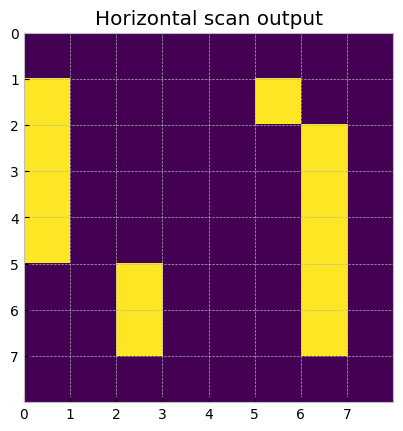

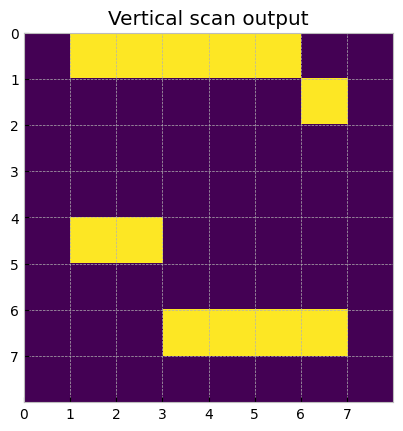

In [7]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

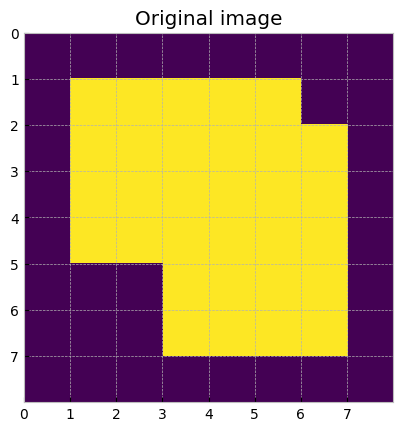

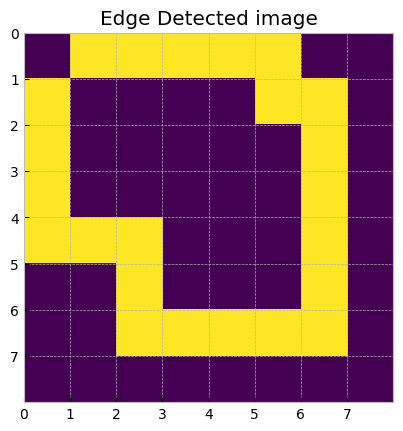

In [8]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


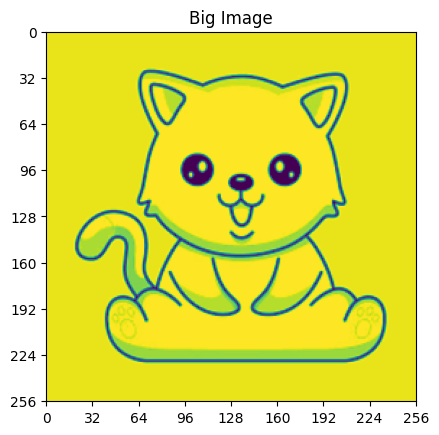

In [85]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 8    # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('catt.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)

image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [86]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [87]:
crops=[]
for i in range(image_size//image_crop_size):
    for j in range(image_size//image_crop_size):
        crops.append(image[i*image_crop_size:(i+1)*image_crop_size,j*image_crop_size:(j+1)*image_crop_size])

In [88]:
edge_crops=[]
x=0
for crop in crops:
    if not((crop==0).all() or (crop==1).all()):
        # Horizontal: Original image
        image_norm_h = amplitude_encode(crop)

        # Vertical: Transpose of Original image
        image_norm_v = amplitude_encode(crop.T)
        # Create the circuit for horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)

        # Create the circuit for vertical scan
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)

        # Combine both circuits into a single list
        circ_list = [qc_h, qc_v]

        # Simulating the cirucits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)

        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

        # Selecting odd states from the raw statevector and
        # reshaping column vector of size 64 to an 8x8 matrix
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T
        edge_scan_sim = edge_scan_h | edge_scan_v

        edge_crops.append(edge_scan_sim)

    else:
        edge_crops.append(crop)

    if x%32==0:
        print(x)
    x+=1

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992


In [89]:
tmps=[]
for j in range(32):
    init=edge_crops[32*j]
    for i in range(1,32):
        init=np.concatenate((init, edge_crops[32*j+i]), axis=1)
    tmps.append(init)

In [90]:
print(init.shape)
print(len(tmps))

(8, 256)
32


In [91]:
actual_edge_image=tmps[0]
for i in range(1,32):
    actual_edge_image=np.concatenate((actual_edge_image, tmps[i]), axis=0)

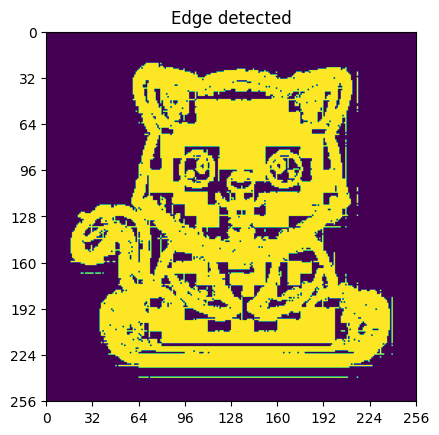

In [92]:
plt.title('Edge detected')
plt.xticks(range(0, actual_edge_image.shape[0]+1, 32))
plt.yticks(range(0, actual_edge_image.shape[1]+1, 32))
plt.imshow(actual_edge_image, extent=[0, actual_edge_image.shape[0], actual_edge_image.shape[1], 0], cmap='viridis')
plt.show()

Raw Image info: (256, 256, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


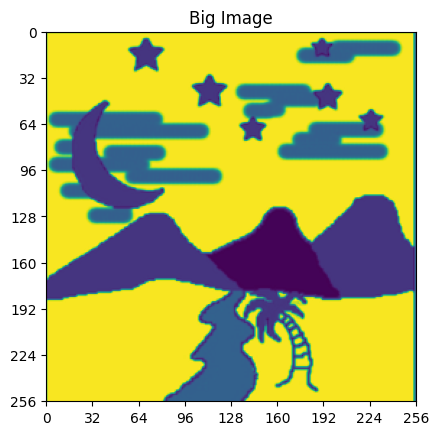

In [13]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 8  # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('ex1.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)

image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [14]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [15]:
crops=[]
for i in range(image_size//image_crop_size):
    for j in range(image_size//image_crop_size):
        crops.append(image[i*image_crop_size:(i+1)*image_crop_size,j*image_crop_size:(j+1)*image_crop_size])

In [18]:
edge_crops=[]
x=0
for crop in crops:
    if not((crop==0).all() or (crop==1).all()):
        # Horizontal: Original image
        image_norm_h = amplitude_encode(crop)

        # Vertical: Transpose of Original image
        image_norm_v = amplitude_encode(crop.T)
        # Create the circuit for horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        #display(qc_h.draw('mpl', fold=-1))

        # Create the circuit for vertical scan
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        #display(qc_v.draw('mpl', fold=-1))

        # Combine both circuits into a single list
        circ_list = [qc_h, qc_v]

        # Simulating the cirucits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)

        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

        # Selecting odd states from the raw statevector and
        # reshaping column vector of size 64 to an 8x8 matrix
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T
        edge_scan_sim = edge_scan_h | edge_scan_v

        edge_crops.append(edge_scan_sim)

    else:
        edge_crops.append(crop)

    if x%32==0:
        print(x)
    x+=1

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992


In [19]:
tmps=[]
for j in range(32):
    init=edge_crops[32*j]
    for i in range(1,32):
        init=np.concatenate((init, edge_crops[32*j+i]), axis=1)
    tmps.append(init)

In [20]:
print(init.shape)
print(len(tmps))

(8, 256)
32


In [21]:
actual_edge_image=tmps[0]
for i in range(1,32):
    actual_edge_image=np.concatenate((actual_edge_image, tmps[i]), axis=0)

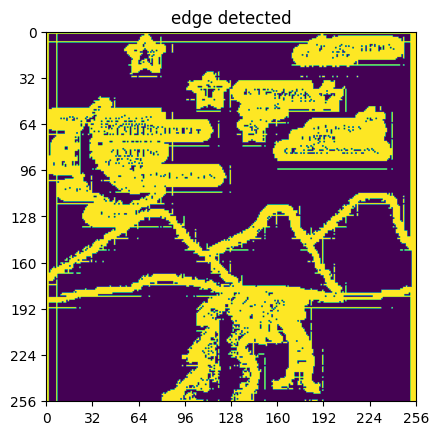

In [22]:
plt.title('edge detected')
plt.xticks(range(0, actual_edge_image.shape[0]+1, 32))
plt.yticks(range(0, actual_edge_image.shape[1]+1, 32))
plt.imshow(actual_edge_image, extent=[0, actual_edge_image.shape[0], actual_edge_image.shape[1], 0], cmap='viridis')
plt.show()

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


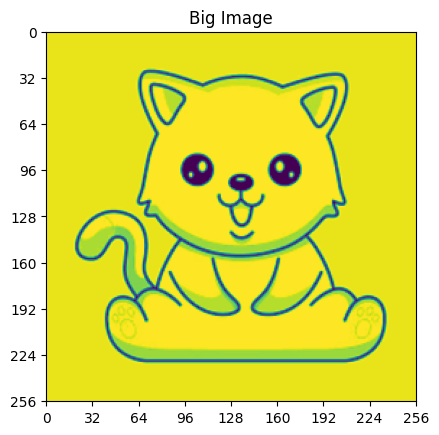

In [93]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 4   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('catt.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)

image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [94]:
# Initialize some global variable for number of qubits
data_qb = 4
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [95]:
crops=[]
for i in range(image_size//image_crop_size):
    for j in range(image_size//image_crop_size):
        crops.append(image[i*image_crop_size:(i+1)*image_crop_size,j*image_crop_size:(j+1)*image_crop_size])

In [96]:
edge_crops=[]
x=0
for crop in crops:
    if not((crop==0).all() or (crop==1).all()):
        # Horizontal: Original image
        image_norm_h = amplitude_encode(crop)

        # Vertical: Transpose of Original image
        image_norm_v = amplitude_encode(crop.T)
        # Create the circuit for horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        #display(qc_h.draw('mpl', fold=-1))

        # Create the circuit for vertical scan
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        #display(qc_v.draw('mpl', fold=-1))

        # Combine both circuits into a single list
        circ_list = [qc_h, qc_v]

        # Simulating the cirucits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)

        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

        # Selecting odd states from the raw statevector and
        # reshaping column vector of size 64 to an 8x8 matrix
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(4, 4)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(4, 4).T
        edge_scan_sim = edge_scan_h | edge_scan_v

        edge_crops.append(edge_scan_sim)

    else:
        edge_crops.append(crop)

    if x%64==0:
        print(x)
    x+=1

0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032


In [97]:
tmps=[]
for j in range(64):
    init=edge_crops[64*j]
    for i in range(1,64):
        init=np.concatenate((init, edge_crops[64*j+i]), axis=1)
    tmps.append(init)

In [98]:
print(init.shape)
print(len(tmps))

(4, 256)
64


In [99]:
actual_edge_image=tmps[0]
for i in range(1,64):
    actual_edge_image=np.concatenate((actual_edge_image, tmps[i]), axis=0)

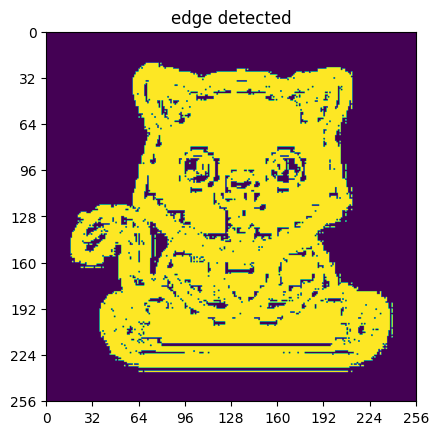

In [100]:
plt.title('edge detected')
plt.xticks(range(0, actual_edge_image.shape[0]+1, 32))
plt.yticks(range(0, actual_edge_image.shape[1]+1, 32))
plt.imshow(actual_edge_image, extent=[0, actual_edge_image.shape[0], actual_edge_image.shape[1], 0], cmap='viridis')
plt.show()